# MM2 Data Analysis - True EP Incidence + Characteristics

## Data Collection Form

<img src="assets/EP1.png"/>

<img src="assets/EP2.png"/>

<img src="assets/TypesEmergencyMOD.png"/>

## Imports

In [1]:
import math
import numpy as np
import pandas as pd

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

from datetime import datetime, timedelta
import re

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)

## Parameters

## Input

In [3]:
crc_df = pd.read_csv('Data/mm2_crc_merged.csv', engine='python')
crc_df['StudyID'] = crc_df['ï»¿StudyID']
crc_df = crc_df.drop('ï»¿StudyID', axis=1)

In [4]:
lca_df = pd.read_csv('Data/mm2_lca_merged.csv', engine='python')
lca_df['StudyID'] = lca_df['ï»¿StudyID']
lca_df = lca_df.drop('ï»¿StudyID', axis=1)

## Processing

### Functions

In [5]:
# true EPs are ones where reviewer says it is unplanned, is really first time cancer dx, and there is a cancer signal
def is_true_EP (row):
    if (row['UnplanVal'] == 'Yes' and row['DxVal'] == 'Yes' and not pd.isnull(row['RelSig'])):
        return 1
    else:
        return 0

In [6]:
# true EPs are ones where reviewer says it is unplanned, is really first time cancer dx, and there is a cancer signal
def is_true_EP (row):
    if (row['UnplanVal'] == 'Yes' and row['DxVal'] == 'Yes' and not pd.isnull(row['RelSig'])):
        return 1
    else:
        return 0

In [7]:
def response_num_to_text (row):
    if (row['RelRespNumerical'] == 1):
        return 'No signal requiring f/u'
    elif (row['RelRespNumerical'] == 2):
        return 'Signal not recognized'
    elif (row['RelRespNumerical'] == 3):
        return 'Signal recognized, f/u not initiated'
    elif (row['RelRespNumerical'] == 4):
        return 'Signal recognized, OP f/u'
    elif (row['RelRespNumerical'] == 5):
        return 'Signal recognized, IP f/u'
    elif (row['RelRespNumerical'] == 6):
        return 'Other'
    #else:
        #return 'ERROR'

In [8]:
def typeep_num_to_text (row):
    if (row['TypeOfEP'] == 1):
        return 'Dx within emergency event'
    elif (row['TypeOfEP'] == 2):
        return 'Cancer-related emergency → Related subsequent encounter'
    elif (row['TypeOfEP'] == 3):
        return 'Non-cancer-related emergency → Related subsequent encounter'
    elif (row['TypeOfEP'] == 4):
        return 'Non-cancer-related emergency → Unrelated subsequent encounter'
    elif (row['TypeOfEP'] == 5):
        return 'Other'
    #else:
        #return 'ERROR'

In [9]:
def parse_datetime1 (row, col):
    try:
        return datetime.strptime(row[col], '%m/%d/%Y')
    except:
        return None

In [10]:
def parse_datetime2 (row, col):
    try:
        return datetime.strptime(str(row[col]), '%Y-%m-%d')
    except:
        return None

In [11]:
def is_timedelta_within_threshold (row, col_later, col_earlier, threshold):
    try:
        delta = (row[col_later] - row[col_earlier]).days
        if delta <= threshold:
            return 1
        else:
            return 0
    except:
        return -1

In [12]:
def parse_yesno_1 (row, col):
    if (row[col] == 'Yes'):
        return 1
    else:
        return 0

In [13]:
def parse_01_1 (row, col):
    if (row[col] == 1):
        return 1
    else:
        return 0

In [14]:
def check_not_null (row, col):
    if not pd.isnull(row[col]):
        return 1
    else:
        return 0

In [15]:
# make columns for each individual signal for CRC
def get_crc_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_02 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('2' in str(x) and not '12' in str(x)):
                return 1
        return 0
    else:
        if ('2' in str(row['RelSig']) and not '12' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_03 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('3' in str(x) and not '13' in str(x)):
                return 1
        return 0
    else:
        if ('3' in str(row['RelSig']) and not '13' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_04 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('4' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('4' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_crc_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_11 (row):
    if ('11' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_12 (row):
    if ('12' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_13 (row):
    if ('13' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_crc_sig_14 (row):
    if ('14' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [16]:
# make columns for each individual signal for LCa
def get_lca_sig_01 (row):
    if ';' in str(row['RelSig']):
        for x in str(row['RelSig']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RelSig']) and not '10' in str(row['RelSig']) and not '11' in str(row['RelSig']) and not '12' in str(row['RelSig']) and not '13' in str(row['RelSig']) and not '14' in str(row['RelSig'])):
            return 1
        else:
            return 0
    
def get_lca_sig_02 (row):
    if ('2' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_03 (row):
    if ('3' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_04 (row):
    if ('4' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_05 (row):
    if ('5' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_06 (row):
    if ('6' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_07 (row):
    if ('7' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_08 (row):
    if ('8' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_09 (row):
    if ('9' in str(row['RelSig'])):
        return 1
    else:
        return 0
    
def get_lca_sig_10 (row):
    if ('10' in str(row['RelSig'])):
        return 1
    else:
        return 0

In [17]:
# make columns for each individual RF for CRC
def get_crc_redf_01 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RFInitialRF']) and not '10' in str(row['RFInitialRF']) and not '11' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_02 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('2' in str(x) and not '12' in str(x)):
                return 1
        return 0
    else:
        if ('2' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_03 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('3' in str(x) and not '13' in str(x)):
                return 1
        return 0
    else:
        if ('3' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_04 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('4' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('4' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_crc_redf_05 (row):
    if ('5' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_06 (row):
    if ('6' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_07 (row):
    if ('7' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_08 (row):
    if ('8' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_09 (row):
    if ('9' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_10 (row):
    if ('10' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_11 (row):
    if ('11' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_12 (row):
    if ('12' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_13 (row):
    if ('13' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_crc_redf_14 (row):
    if ('14' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0

In [18]:
# make columns for each individual signal for LCa
def get_lca_redf_01 (row):
    if ';' in str(row['RFInitialRF']):
        for x in str(row['RFInitialRF']).split(';'):
            if ('1' in str(x) and not '10' in str(x) and not '11' in str(x) and not '12' in str(x) and not '13' in str(x) and not '14' in str(x)):
                return 1
        return 0
    else:
        if ('1' in str(row['RFInitialRF']) and not '10' in str(row['RFInitialRF']) and not '11' in str(row['RFInitialRF']) and not '12' in str(row['RFInitialRF']) and not '13' in str(row['RFInitialRF']) and not '14' in str(row['RFInitialRF'])):
            return 1
        else:
            return 0
    
def get_lca_redf_02 (row):
    if ('2' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_03 (row):
    if ('3' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_04 (row):
    if ('4' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_05 (row):
    if ('5' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_06 (row):
    if ('6' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_07 (row):
    if ('7' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_08 (row):
    if ('8' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_09 (row):
    if ('9' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0
    
def get_lca_redf_10 (row):
    if ('10' in str(row['RFInitialRF'])):
        return 1
    else:
        return 0

In [19]:
def get_column_stats(col, mean_col, df):
    df_stats = df[col].agg(['mean', 'std', 'count'])
    
    df_stats['ci95_hi'] = (df_stats['mean'] + 1.96 * df_stats['std']/math.sqrt(df_stats['count'])) * 100
    df_stats['ci95_lo'] = (df_stats['mean'] - 1.96 * df_stats['std']/math.sqrt(df_stats['count'])) * 100
    df_stats[mean_col] = df_stats['mean'] * 100
    
    return df_stats

### Apply

In [20]:
crc_df['TrueEP'] = crc_df.apply(lambda row: is_true_EP(row), axis=1)
lca_df['TrueEP'] = lca_df.apply(lambda row: is_true_EP(row), axis=1)

In [21]:
crc_df['ResponseText'] = crc_df.apply(lambda row: response_num_to_text(row), axis=1)
crc_df['ResponseText'] = pd.Categorical(crc_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)
lca_df['ResponseText'] = lca_df.apply(lambda row: response_num_to_text(row), axis=1)
lca_df['ResponseText'] = pd.Categorical(lca_df['ResponseText'], categories=['No signal requiring f/u', 'Signal not recognized', 'Signal recognized, f/u not initiated', 'Signal recognized, OP f/u', 'Signal recognized, IP f/u', 'Other'], ordered=True)

In [22]:
crc_df['TypeEPText'] = crc_df.apply(lambda row: typeep_num_to_text(row), axis=1)
crc_df['TypeEPText'] = pd.Categorical(crc_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Unrelated subsequent encounter', 'Other'], ordered=True)
lca_df['TypeEPText'] = lca_df.apply(lambda row: typeep_num_to_text(row), axis=1)
lca_df['TypeEPText'] = pd.Categorical(lca_df['TypeEPText'], categories=['Dx within emergency event', 'Cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Related subsequent encounter', 'Non-cancer-related emergency → Unrelated subsequent encounter', 'Other'], ordered=True)

In [23]:
crc_df['ScreeningTestDateTime'] = crc_df.apply(lambda row: parse_datetime1(row, 'DiagnosticTestDate'), axis=1)
lca_df['ScreeningTestDateTime'] = lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticTestDate'), axis=1)
crc_df['DiagnosisDateTime'] = crc_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)
lca_df['DiagnosisDateTime'] = lca_df.apply(lambda row: parse_datetime2(row, 'DiagnosticEventDateTime'), axis=1)

crc_df['ScreeningUpToDate'] = crc_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)
lca_df['ScreeningUpToDate'] = lca_df.apply(lambda row: is_timedelta_within_threshold(row, 'DiagnosisDateTime', 'ScreeningTestDateTime', 3650), axis=1)

In [24]:
crc_df['RFPriorToDx'] = crc_df.apply(lambda row: parse_yesno_1(row, 'RFYesNo'), axis=1)
# lung cancer is already in 1 0 format
lca_df['RFPriorToDx'] = lca_df.apply(lambda row: parse_01_1(row, 'RFYesNo'), axis=1)

In [25]:
crc_df['HasMOD'] = crc_df.apply(lambda row: parse_yesno_1(row, 'DxMOD'), axis=1)
# lung cancer is already in 1 0 format
lca_df['HasMOD'] = lca_df.apply(lambda row: parse_01_1(row, 'DxMOD'), axis=1)

In [26]:
crc_df['DimensionPtRelated_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
crc_df['DimensionPtProvEncounter_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
crc_df['DimensionDxTests_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
crc_df['DimensionFupTrack_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
crc_df['DimensionReferrals_Parsed'] = crc_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

lca_df['DimensionPtRelated_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionPtRelated'), axis=1)
lca_df['DimensionPtProvEncounter_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionPtProvEncounter'), axis=1)
lca_df['DimensionDxTests_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionDxTests'), axis=1)
lca_df['DimensionFupTrack_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionFupTrack'), axis=1)
lca_df['DimensionReferrals_Parsed'] = lca_df.apply(lambda row: check_not_null(row, 'DimensionReferrals'), axis=1)

In [27]:
crc_df['Signal_IDA'] = crc_df.apply(lambda row: get_crc_sig_01(row), axis=1)
crc_df['Signal_Obstruction'] = crc_df.apply(lambda row: get_crc_sig_02(row), axis=1)
crc_df['Signal_BloodyStool'] = crc_df.apply(lambda row: get_crc_sig_03(row), axis=1)
crc_df['Signal_AbdMass'] = crc_df.apply(lambda row: get_crc_sig_04(row), axis=1)
crc_df['Signal_RectMass'] = crc_df.apply(lambda row: get_crc_sig_05(row), axis=1)
crc_df['Signal_StoolCaliber'] = crc_df.apply(lambda row: get_crc_sig_06(row), axis=1)
crc_df['Signal_CScope'] = crc_df.apply(lambda row: get_crc_sig_07(row), axis=1)
crc_df['Signal_FOBT'] = crc_df.apply(lambda row: get_crc_sig_08(row), axis=1)
crc_df['Signal_FlexSig'] = crc_df.apply(lambda row: get_crc_sig_09(row), axis=1)
crc_df['Signal_Enema'] = crc_df.apply(lambda row: get_crc_sig_10(row), axis=1)
crc_df['Signal_CT'] = crc_df.apply(lambda row: get_crc_sig_11(row), axis=1)
crc_df['Signal_FamHx'] = crc_df.apply(lambda row: get_crc_sig_12(row), axis=1)
crc_df['Signal_MassExam'] = crc_df.apply(lambda row: get_crc_sig_13(row), axis=1)
crc_df['Signal_Other'] = crc_df.apply(lambda row: get_crc_sig_14(row), axis=1)

In [28]:
lca_df['Signal_Cough'] = lca_df.apply(lambda row: get_lca_sig_01(row), axis=1)
lca_df['Signal_Dyspnea'] = lca_df.apply(lambda row: get_lca_sig_02(row), axis=1)
lca_df['Signal_ChestPain'] = lca_df.apply(lambda row: get_lca_sig_03(row), axis=1)
lca_df['Signal_Hemoptysis'] = lca_df.apply(lambda row: get_lca_sig_04(row), axis=1)
lca_df['Signal_LRTI'] = lca_df.apply(lambda row: get_lca_sig_05(row), axis=1)
lca_df['Signal_Imaging'] = lca_df.apply(lambda row: get_lca_sig_06(row), axis=1)
lca_df['Signal_Paraneoplastic'] = lca_df.apply(lambda row: get_lca_sig_07(row), axis=1)
lca_df['Signal_Hoarse'] = lca_df.apply(lambda row: get_lca_sig_08(row), axis=1)
lca_df['Signal_WtLoss'] = lca_df.apply(lambda row: get_lca_sig_09(row), axis=1)
lca_df['Signal_Other'] = lca_df.apply(lambda row: get_lca_sig_10(row), axis=1)

In [29]:
crc_df['Redf_IDA'] = crc_df.apply(lambda row: get_crc_redf_01(row), axis=1)
crc_df['Redf_Obstruction'] = crc_df.apply(lambda row: get_crc_redf_02(row), axis=1)
crc_df['Redf_BloodyStool'] = crc_df.apply(lambda row: get_crc_redf_03(row), axis=1)
crc_df['Redf_AbdMass'] = crc_df.apply(lambda row: get_crc_redf_04(row), axis=1)
crc_df['Redf_RectMass'] = crc_df.apply(lambda row: get_crc_redf_05(row), axis=1)
crc_df['Redf_StoolCaliber'] = crc_df.apply(lambda row: get_crc_redf_06(row), axis=1)
crc_df['Redf_CScope'] = crc_df.apply(lambda row: get_crc_redf_07(row), axis=1)
crc_df['Redf_FOBT'] = crc_df.apply(lambda row: get_crc_redf_08(row), axis=1)
crc_df['Redf_FlexSig'] = crc_df.apply(lambda row: get_crc_redf_09(row), axis=1)
crc_df['Redf_Enema'] = crc_df.apply(lambda row: get_crc_redf_10(row), axis=1)
crc_df['Redf_CT'] = crc_df.apply(lambda row: get_crc_redf_11(row), axis=1)
crc_df['Redf_FamHx'] = crc_df.apply(lambda row: get_crc_redf_12(row), axis=1)
crc_df['Redf_MassExam'] = crc_df.apply(lambda row: get_crc_redf_13(row), axis=1)
crc_df['Redf_Other'] = crc_df.apply(lambda row: get_crc_redf_14(row), axis=1)

In [30]:
lca_df['Redf_Cough'] = lca_df.apply(lambda row: get_lca_redf_01(row), axis=1)
lca_df['Redf_Dyspnea'] = lca_df.apply(lambda row: get_lca_redf_02(row), axis=1)
lca_df['Redf_ChestPain'] = lca_df.apply(lambda row: get_lca_redf_03(row), axis=1)
lca_df['Redf_Hemoptysis'] = lca_df.apply(lambda row: get_lca_redf_04(row), axis=1)
lca_df['Redf_LRTI'] = lca_df.apply(lambda row: get_lca_redf_05(row), axis=1)
lca_df['Redf_Imaging'] = lca_df.apply(lambda row: get_lca_redf_06(row), axis=1)
lca_df['Redf_Paraneoplastic'] = lca_df.apply(lambda row: get_lca_redf_07(row), axis=1)
lca_df['Redf_Hoarse'] = lca_df.apply(lambda row: get_lca_redf_08(row), axis=1)
lca_df['Redf_WtLoss'] = lca_df.apply(lambda row: get_lca_redf_09(row), axis=1)
lca_df['Redf_Other'] = lca_df.apply(lambda row: get_lca_redf_10(row), axis=1)

In [31]:
# mm2_crc_df[['RelSig', 'Signal_IDA', 'Signal_Obstruction', 'Signal_BloodyStool', 'Signal_AbdMass', 'Signal_RectMass', 'Signal_StoolCaliber', 'Signal_CScope', 'Signal_FOBT', 'Signal_FlexSig', 'Signal_Enema', 'Signal_CT', 'Signal_FamHx', 'Signal_MassExam', 'Signal_Other']]

In [32]:
# mm2_lca_df[['RelSig', 'Signal_Cough', 'Signal_Dyspnea', 'Signal_ChestPain', 'Signal_Hemoptysis', 'Signal_LRTI', 'Signal_Imaging', 'Signal_Paraneoplastic', 'Signal_Hoarse', 'Signal_WtLoss', 'Signal_Other']]

In [49]:
lca_sig_master = pd.DataFrame(columns=['Signal', 'True EP', 'True MOD'])

for x in lca_df.index:
    if lca_df.loc[x]['Signal_Cough'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Dyspnea'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Dyspnea', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_ChestPain'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Chest Pain', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Hemoptysis'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hemoptysis', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_LRTI'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['LRTI', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Imaging'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Imaging', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Paraneoplastic'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Hoarse'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Hoarse', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_WtLoss'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Weight Loss', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Other'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Other', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    if lca_df.loc[x]['Signal_Cough'] == 1:
        lca_sig_master.loc[len(lca_sig_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]
    

In [50]:
crc_sig_master = pd.DataFrame(columns=['Signal', 'True EP', 'True MOD'])

for x in crc_df.index:
    if crc_df.loc[x]['Signal_IDA'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['IDA', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Obstruction'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Obstruction', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_BloodyStool'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Bloody Stool', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_AbdMass'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Abdominal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_RectMass'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Rectal Mass', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_StoolCaliber'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Stool Caliber', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_CScope'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Colonoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FOBT'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['FOBT', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FlexSig'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Flexible Sigmoidoscopy', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Enema'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Barium Enema', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_CT'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['CT Finding', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_FamHx'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Family History', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_MassExam'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Mass on Examination', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]
    if crc_df.loc[x]['Signal_Other'] == 1:
        crc_sig_master.loc[len(crc_sig_master.index)] = ['Other', crc_df.loc[x]['TrueEP'], crc_df.loc[x]['HasMOD']]

In [ ]:
lca_fu_master = pd.DataFrame(columns=['Follow-Up', 'True EP', 'True MOD'])

for x in lca_df.index:
    if lca_df.loc[x]['Signal_Cough'] == 1:
        lca_fu_master.loc[len(lca_fu_master.index)] = ['Cough', lca_df.loc[x]['TrueEP'], lca_df.loc[x]['HasMOD']]

## Descriptive Stats

### True EP Rate

#### Lung Cancer

In [33]:
lca_tep_stats = get_column_stats('TrueEP', '% True EP', lca_df)
lca_tep_stats

mean           0.800000
std            0.402015
count        100.000000
ci95_hi       87.879496
ci95_lo       72.120504
% True EP     80.000000
Name: TrueEP, dtype: float64

#### CRC

In [34]:
crc_tep_stats = get_column_stats('TrueEP', '% True EP', crc_df)
crc_tep_stats

mean           0.730000
std            0.446196
count        100.000000
ci95_hi       81.745442
ci95_lo       64.254558
% True EP     73.000000
Name: TrueEP, dtype: float64

### Signals

#### LCa

In [35]:
lca_sigf_df = pd.DataFrame({'Signal':['Cough', 'Dyspnea', 'ChestPain', 'Hemoptysis', 'LRTI', 'Imaging', 'Paraneoplastic', 'Hoarse', 'WtLoss', 'Other']})
lca_sigf_vals = [] 

lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Cough'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Dyspnea'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_ChestPain'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Hemoptysis'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_LRTI'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Imaging'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Paraneoplastic'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Hoarse'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_WtLoss'].agg('mean') * 100)
lca_sigf_vals.append(lca_df[lca_df['TrueEP'] == 1]['Signal_Other'].agg('mean') * 100)

lca_sigf_df['Frequency'] = lca_sigf_vals
lca_sigf_df = lca_sigf_df.sort_values(by='Frequency', ascending=False)

In [36]:
lca_sigf_df

,Signal,Frequency
5,Imaging,82.50
1,Dyspnea,43.75
0,Cough,28.75
2,ChestPain,23.75
3,Hemoptysis,15.00
8,WtLoss,13.75
4,LRTI,7.50
6,Paraneoplastic,1.25
9,Other,1.25
7,Hoarse,0.00


(0.0, 1.0)

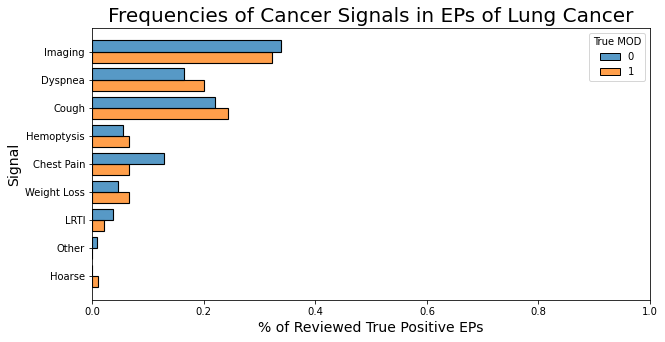

In [54]:
lca_sig_plt = sns.histplot(data=lca_sig_master, y='Signal', hue='True MOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
lca_sig_plt.axes.set_title("Frequencies of Cancer Signals in EPs of Lung Cancer", fontsize=20)
lca_sig_plt.axes.set_ylabel ("Signal", fontsize=14)
lca_sig_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_sig_plt.axes.set_xlim ([0, 1])

#### CRC

In [38]:
crc_sigf_df = pd.DataFrame({'Signal':['IDA', 'Obstruction', 'BloodyStool', 'AbdMass', 'RectMass', 'StoolCaliber', 'CScope', 'FOBT', 'FlexSig', 'Enema', 'CT', 'FamHx', 'MassExam', 'Other']})
crc_sigf_vals = [] 

crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_IDA'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_Obstruction'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_BloodyStool'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_AbdMass'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_RectMass'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_StoolCaliber'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_CScope'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_FOBT'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_FlexSig'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_Enema'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_CT'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_FamHx'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_MassExam'].agg('mean') * 100)
crc_sigf_vals.append(crc_df[crc_df['TrueEP'] == 1]['Signal_Other'].agg('mean') * 100)

crc_sigf_df['Frequency'] = crc_sigf_vals
crc_sigf_df = crc_sigf_df.sort_values(by='Frequency', ascending=False)

In [39]:
crc_sigf_df

,Signal,Frequency
0,IDA,52.054795
10,CT,47.945205
2,BloodyStool,30.136986
5,StoolCaliber,17.808219
6,CScope,16.438356
1,Obstruction,8.219178
4,RectMass,6.849315
3,AbdMass,4.109589
7,FOBT,4.109589
11,FamHx,2.739726


(0.0, 1.0)

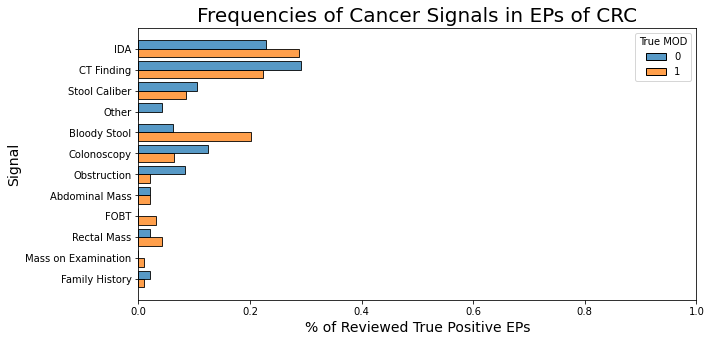

In [53]:
crc_sig_plt = sns.histplot(data=crc_sig_master, y='Signal', hue='True MOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
crc_sig_plt.axes.set_title("Frequencies of Cancer Signals in EPs of CRC", fontsize=20)
crc_sig_plt.axes.set_ylabel ("Signal", fontsize=14)
crc_sig_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_sig_plt.axes.set_xlim ([0, 1])

### Clinical Response

#### LCa

In [88]:
lca_resp_df = lca_df[lca_df['TrueEP'] == 1].groupby('ResponseText')['TrueEP'].agg(['count'])
lca_resp_df

,count
ResponseText,
No signal requiring f/u,1
Signal not recognized,2
"Signal recognized, f/u not initiated",0
"Signal recognized, OP f/u",22
"Signal recognized, IP f/u",55
Other,0


(0.0, 1.0)

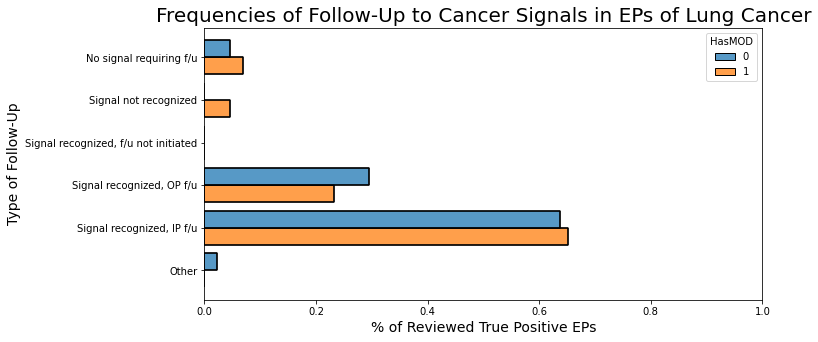

In [90]:
lca_resp_plt = sns.histplot(data=lca_df[~lca_df['ResponseText'].isnull()], y='ResponseText', hue='HasMOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
lca_resp_plt.axes.set_title("Frequencies of Follow-Up to Cancer Signals in EPs of Lung Cancer", fontsize=20)
lca_resp_plt.axes.set_ylabel ("Type of Follow-Up", fontsize=14)
lca_resp_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_resp_plt.axes.set_xlim ([0, 1])

#### CRC

In [43]:
crc_resp_df = crc_df[crc_df['TrueEP'] == 1].groupby('ResponseText')['TrueEP'].agg(['count'])
crc_resp_df

,count
ResponseText,
No signal requiring f/u,0
Signal not recognized,2
"Signal recognized, f/u not initiated",0
"Signal recognized, OP f/u",13
"Signal recognized, IP f/u",55
Other,3


(0.0, 1.0)

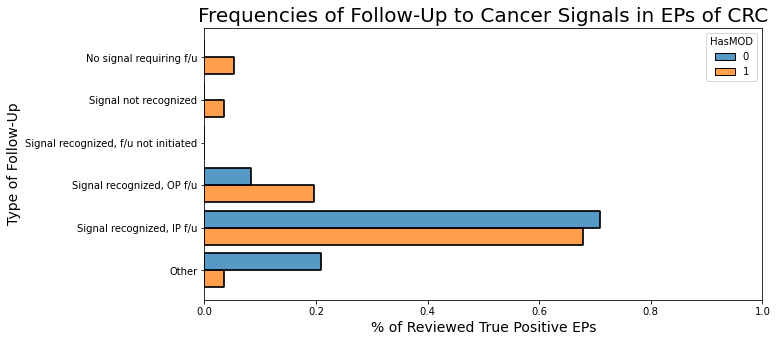

In [91]:
crc_resp_plt = sns.histplot(data=crc_df[~crc_df['ResponseText'].isnull()], y='ResponseText', hue='HasMOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
crc_resp_plt.axes.set_title("Frequencies of Follow-Up to Cancer Signals in EPs of CRC", fontsize=20)
crc_resp_plt.axes.set_ylabel ("Type of Follow-Up", fontsize=14)
crc_resp_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_resp_plt.axes.set_xlim ([0, 1])

### Type of Emergency Event

### Type of EP

#### LCa

In [45]:
lca_typeep_df = lca_df[lca_df['TrueEP'] == 1].groupby('TypeEPText')['TrueEP'].agg(['count'])
lca_typeep_df

,count
TypeEPText,
Dx within emergency event,45
Cancer-related emergency → Related subsequent encounter,20
Non-cancer-related emergency → Related subsequent encounter,12
Non-cancer-related emergency → Unrelated subsequent encounter,1
Other,2


(0.0, 1.0)

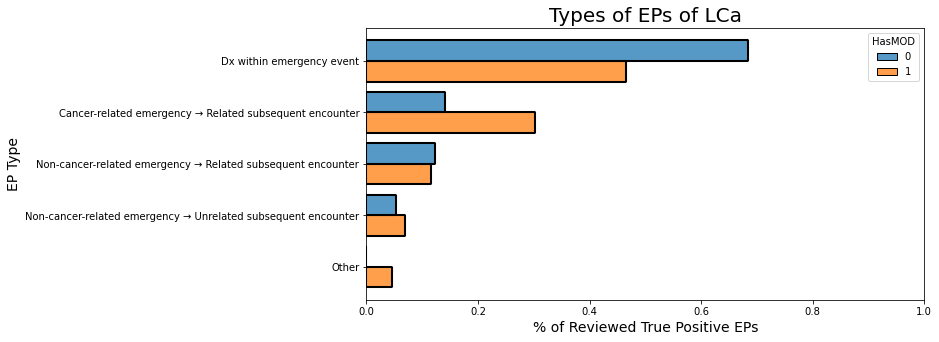

In [95]:
lca_typeep_plt = sns.histplot(data=lca_df[~lca_df['TypeEPText'].isnull()], y='TypeEPText', hue='HasMOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
lca_typeep_plt.axes.set_title("Types of EPs of LCa", fontsize=20)
lca_typeep_plt.axes.set_ylabel ("EP Type", fontsize=14)
lca_typeep_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
lca_typeep_plt.axes.set_xlim ([0, 1])

#### CRC

In [47]:
crc_typeep_df = crc_df[crc_df['TrueEP'] == 1].groupby('TypeEPText')['TrueEP'].agg(['count'])
crc_typeep_df

,count
TypeEPText,
Dx within emergency event,51
Cancer-related emergency → Related subsequent encounter,12
Non-cancer-related emergency → Related subsequent encounter,8
Non-cancer-related emergency → Unrelated subsequent encounter,2
Other,0


(0.0, 1.0)

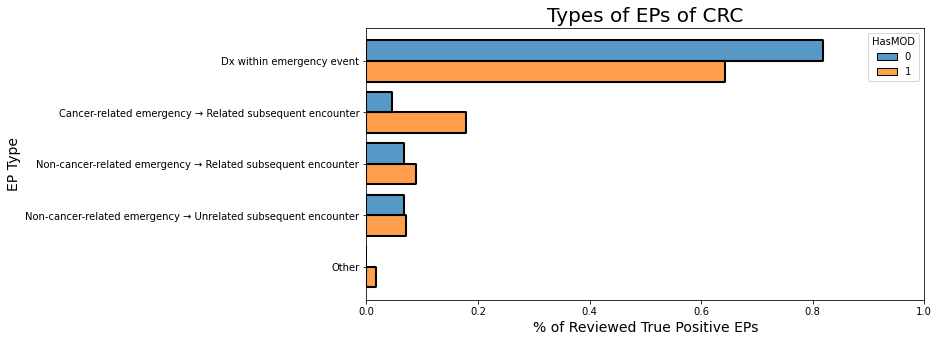

In [96]:
crc_typeep_plt = sns.histplot(data=crc_df[~crc_df['TypeEPText'].isnull()], y='TypeEPText', hue='HasMOD', multiple='dodge', stat='probability', shrink=0.80, common_norm=False)
crc_typeep_plt.axes.set_title("Types of EPs of CRC", fontsize=20)
crc_typeep_plt.axes.set_ylabel ("EP Type", fontsize=14)
crc_typeep_plt.axes.set_xlabel ("% of Reviewed True Positive EPs", fontsize=14)
crc_typeep_plt.axes.set_xlim ([0, 1])